<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task14(Lite)_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Сегментация стройки

##Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as random
import time
import os
from PIL import Image
from google.colab import files
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Reshape
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Images Import

In [ ]:
img_width = 176 # width of resized image
img_height = 240 # height of resized image 
directory = '/content/drive/MyDrive/Colab Notebooks/Segmentation'
train_directory = '/Тренировочная_стройка' #directory with train sample
val_directory = '/Проверочная_стройка' #directory with test sample

In [ ]:
train_images = [] # empty list for saving original images for train sample
test_images = [] # empty list for saving original images for test sample

cur_time = time.time() # Track current time
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): 
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height)))               
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(train_images)) 

cur_time = time.time() # Track current time
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')):          
    test_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')
print ('Количество изображений: ', len(test_images))

Обучающая выборка загржуена. Время загрузки: 389.64c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 21.29c
Количество изображений:  50


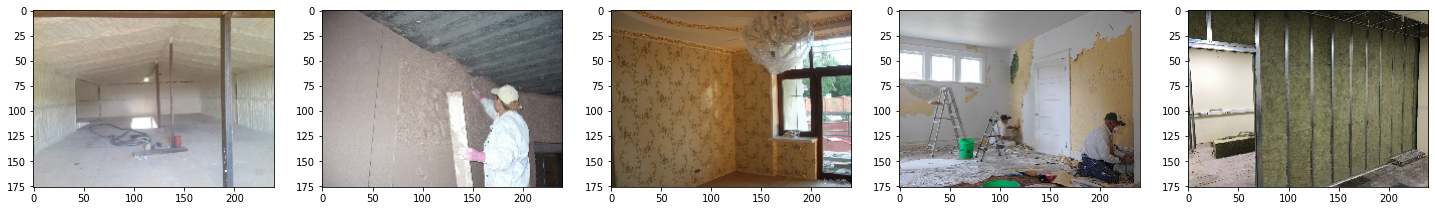

In [ ]:
n = 5 # number of displayed random images
fig, axs = plt.subplots(1, n, figsize=(25, 5))
for i in range(n): 
    img = random.choice(train_images) # Select random image for displaying
    axs[i].imshow(img) # Display image
plt.show()

In [ ]:
train_segments = [] # empty list for saving segmented images for train sample
test_segments = [] # empty list for saving segmented images for test sample

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): 
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height)))  
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):                             
    test_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height))) 
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')
print ('Количество изображений: ', len(test_segments))

Обучающая выборка загржуена. Время загрузки: 738.22c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 37.79c
Количество изображений:  50


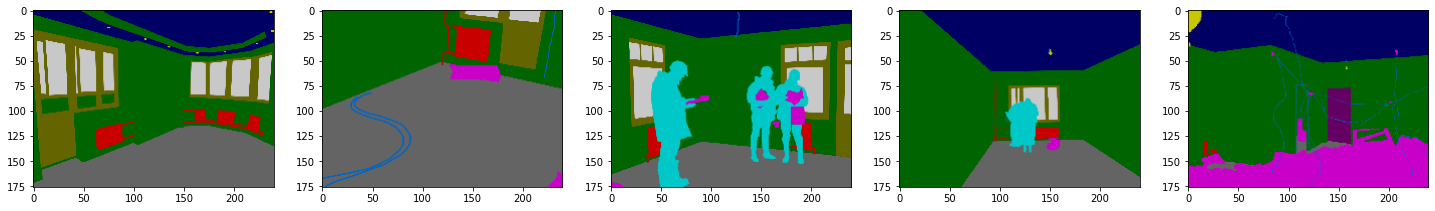

In [ ]:
n = 5 
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n): 
    img = random.choice(train_segments)
    axs[i].imshow(img)
plt.show()

##Samples Creation

In [ ]:
# Creating xTrain
x_train = []
for img in train_images: 
    x = image.img_to_array(img) # Converting image to numpy-array with dimensions: height - width - number_canals
    x_train.append(x) 
x_train = np.array(x_train) 
# Creating xTest
x_test = [] 
for img in test_images: 
    x = image.img_to_array(img) 
    x_test.append(x) 
x_test = np.array(x_test) 

print(x_train.shape) 
print(x_test.shape) 

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
# Converting pixels of segmented images into indexes (6 classes)
def color2index(color):
    index=-1
    if   (149>=color[0]>51)   and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=0 # пол
    #elif (49>=color[0]>=0)    and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=1 # потолок
    #elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=2 # стена
    #elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=4 # колонна
    #elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=3 # проем
    #elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=3 # дверь
    elif (149>=color[0]>=51)  and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=1 # окно
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (249>=color[2]>=151) : index=1 # внешний мир
    #elif (49>=color[0]>=0)    and (49>=color[1]>=51)   and (249>=color[2]>=151) : index=4 # лестница
    #elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # перила
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=2 # батарея
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (249>=color[2]>=151) : index=3 # люди
    #elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # инвентарь
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # источники света
    #elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (249>=color[2]>=151) : index=4 # провода
    #elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=4 # балка
    else: index=5
    return index
num_classes = 6 # number of classes on the image

In [ ]:
#Converting predicted images into colored(segmented) images
def index2color(index2):
    index = np.argmax(index2) # Получаем индекс максимального элемента
    color=[]
    if   index == 0: color = [100, 100, 100]  # пол
    elif index == 1: color = [0, 0, 100]      # окно и внешний мир
    elif index == 2: color = [0, 100, 0]      # батарея
    elif index == 3: color = [100, 0, 0]      # люди
    elif index == 4: color = [0, 100, 100]    # источники света
    elif index == 5: color = [0, 0, 0]        # остальное
    return color # Возвращаем цвет пикслея

In [ ]:
# Converting indexes in to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Reshape into a 2-d array
    yt = [] 
    for i in range(len(y)): 
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Converting pixels of segmented images into indexes and then into OHE
    yt = np.array(yt)
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Reshape into original 3-d array
    return yt 

In [ ]:
# Creating yTrain
def yt_prep(data, num_classes):
    yTrain = [] 
    for seg in data: # Iterate within all segmented images
        y = image.img_to_array(seg) # Converting image to numpy-array with dimensions: height - width - number_canals
        y = rgbToohe(y, num_classes) # Converting indexes into OHE
        yTrain.append(y) 
        if len(yTrain) % 100 == 0: # Each 100 images
            print(len(yTrain)) # Print number of processed images
    return np.array(yTrain) 

In [ ]:
cur_time = time.time() 
y_train = yt_prep(train_segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

100
200
300
400
500
600
700
800
900
Время обработки:  2443.41 c


In [ ]:
# Creating yTest
cur_time = time.time() 
y_test = yt_prep(test_segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

Время обработки:  118.93 c


In [ ]:
print(y_train.shape) 
print(y_test.shape)

(900, 176, 240, 6)
(50, 176, 240, 6)


##Models

In [ ]:
# Visualisation of segmented predicted images
def processImage(model, count = 1, n_classes = 6):
    indexes = np.random.randint(0, len(x_test), count) # Get 5 random indexes
    fig, axs = plt.subplots(3, count, figsize=(25, 5)) 
    for i,idx in enumerate(indexes): 
        predict = np.array(model.predict(x_test[idx].reshape(1, img_width, img_height, 3))) # image prediction
        pr = predict[0]
        pr1 = [] # empty list for segmented image from predict
        pr2 = [] # empty list for segmented image from y_test
        pr = pr.reshape(-1, n_classes) 
        yr = y_test[idx].reshape(-1, n_classes)
        for k in range(len(pr)): # Iterate within all rows (each row contains all classes)
            pr1.append(index2color(pr[k])) # Converting indexes into colors
            pr2.append(index2color(yr[k])) # Converting indexes into colors
        pr1 = np.array(pr1) 
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) 
        pr2 = pr2.reshape(img_width, img_height,3) # reshape to image dimensions
        img = Image.fromarray(pr1.astype('uint8')) # converting array into image
        axs[0,i].imshow(img.convert('RGBA')) # Displaying predicted segmented image in the first row
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Displaying segmented image from y_test in the second row
        axs[2,i].imshow(Image.fromarray(x_test[idx].astype('uint8'))) # Displaying original image in the third row        
    plt.show()

In [ ]:
#Own function that returns metric: intersected area divided by the united area of two areas
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

###U-net Batch_size=15

In [ ]:
def unet(num_classes = 6, input_shape= (176, 240, 3)):
    img_input = Input(input_shape)                                         # Create input layer with input_shape dimensions

    # Block 1
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation layer

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Add Activation and save as block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Add MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Add Activation and save as block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Add MaxPooling2D

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Add Activation and save as block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Add MaxPooling2D

    # Block 4
    x = Conv2D(64, (3, 3), padding='same', name='block4_conv1')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv2')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv3')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Add Activation and save as block_4_out

    x = MaxPooling2D()(block_4_out)                                        # Add MaxPooling2D

    # Block 5
    x = Conv2D(32, (3, 3), padding='same', name='block5_conv1')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv2')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv3')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_5_out = Activation('relu')(x)                                    # Add Activation and save as block_5_out

    # UP 2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = concatenate([x, block_4_out])                                      # Merge above layer with block_4_out
    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = concatenate([x, block_3_out])                                      # Merge above layer with block_3_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    # UP 4
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = concatenate([x, block_2_out])                                      # Merge above layer with block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    # UP 5
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = concatenate([x, block_1_out])                                      # Merge above layer with block_1_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('relu')(x)                                              # Add Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Add Conv2D with softmax activation with num_classes neurons

    model = Model(img_input, x) # Create a model with input 'img_input' and output 'x'

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])
    return model

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3))
history = modelUnet.fit(x_train, y_train, epochs=30, batch_size=15, validation_data=(x_test, y_test))

Epoch 1/30
60/60 [==============================] - 131s 2s/step - loss: 0.7900 - dice_coef: 0.5980 - val_loss: 18.6112 - val_dice_coef: 0.2870
Epoch 2/30
60/60 [==============================] - 127s 2s/step - loss: 0.5491 - dice_coef: 0.7155 - val_loss: 3.1137 - val_dice_coef: 0.3988
Epoch 3/30
60/60 [==============================] - 127s 2s/step - loss: 0.4648 - dice_coef: 0.7606 - val_loss: 1.2084 - val_dice_coef: 0.4920
Epoch 4/30
60/60 [==============================] - 127s 2s/step - loss: 0.4282 - dice_coef: 0.7813 - val_loss: 0.9390 - val_dice_coef: 0.5490
Epoch 5/30
60/60 [==============================] - 127s 2s/step - loss: 0.3869 - dice_coef: 0.8038 - val_loss: 0.8295 - val_dice_coef: 0.5914
Epoch 6/30
60/60 [==============================] - 127s 2s/step - loss: 0.3940 - dice_coef: 0.7995 - val_loss: 0.9777 - val_dice_coef: 0.6273
Epoch 7/30
60/60 [==============================] - 127s 2s/step - loss: 0.3708 - dice_coef: 0.8124 - val_loss: 1.0508 - val_dice_coef: 0.681

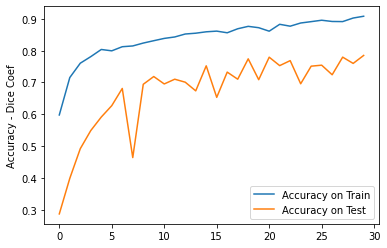

In [ ]:
plt.plot(history.history['dice_coef'], label='Accuracy on Train')
plt.plot(history.history['val_dice_coef'], label='Accuracy on Test')
plt.ylabel('Accuracy - Dice Coef')
plt.legend()
plt.show()

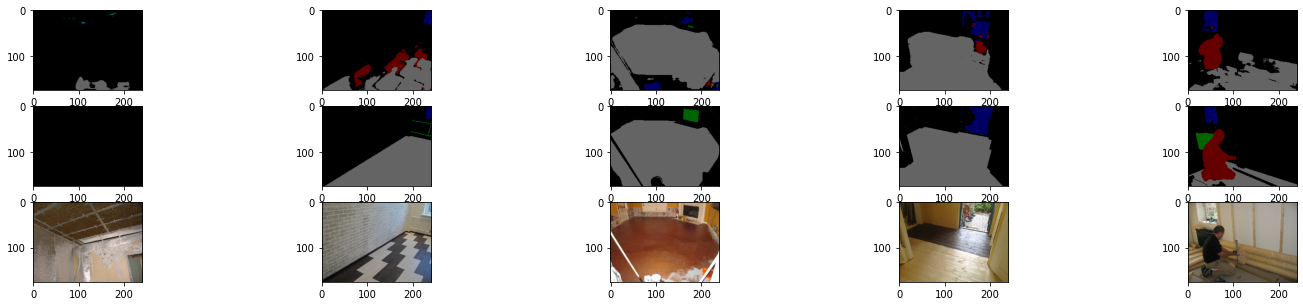

In [ ]:
processImage(modelUnet, 5, num_classes)

###U-net Batch_size=5

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3))
history = modelUnet.fit(x_train, y_train, epochs=30, batch_size=5, validation_data=(x_test, y_test))

Epoch 1/30
180/180 [==============================] - 186s 935ms/step - loss: 0.6510 - dice_coef: 0.6755 - val_loss: 22.1412 - val_dice_coef: 0.1940
Epoch 2/30
180/180 [==============================] - 168s 932ms/step - loss: 0.5035 - dice_coef: 0.7454 - val_loss: 1.1224 - val_dice_coef: 0.5920
Epoch 3/30
180/180 [==============================] - 168s 932ms/step - loss: 0.4657 - dice_coef: 0.7657 - val_loss: 0.9127 - val_dice_coef: 0.6621
Epoch 4/30
180/180 [==============================] - 166s 921ms/step - loss: 0.4434 - dice_coef: 0.7750 - val_loss: 0.7254 - val_dice_coef: 0.6857
Epoch 5/30
180/180 [==============================] - 166s 920ms/step - loss: 0.4101 - dice_coef: 0.7945 - val_loss: 0.9378 - val_dice_coef: 0.5710
Epoch 6/30
180/180 [==============================] - 166s 921ms/step - loss: 0.4016 - dice_coef: 0.7966 - val_loss: 0.6484 - val_dice_coef: 0.7238
Epoch 7/30
180/180 [==============================] - 166s 922ms/step - loss: 0.3831 - dice_coef: 0.8087 - val_

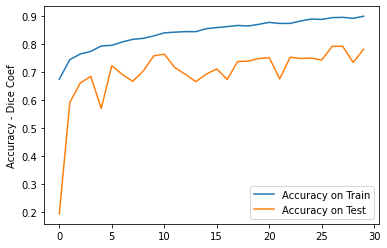

In [ ]:
plt.plot(history.history['dice_coef'], label='Accuracy on Train')
plt.plot(history.history['val_dice_coef'], label='Accuracy on Test')
plt.ylabel('Accuracy - Dice Coef')
plt.legend()
plt.show()

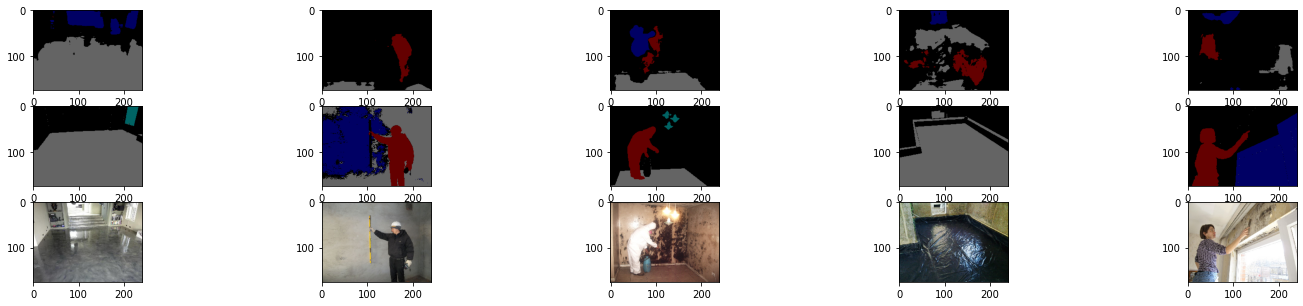

In [ ]:
processImage(modelUnet, 5, num_classes)

###U-net Activation=elu

In [ ]:
def unet_elu(num_classes = 6, input_shape= (176, 240, 3)):
    img_input = Input(input_shape)                                         # Create input layer with input_shape dimensions

    # Block 1
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation layer

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_1_out = Activation('elu')(x)                                    # Add Activation and save as block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Add MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_2_out = Activation('elu')(x)                                    # Add Activation and save as block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Add MaxPooling2D

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_3_out = Activation('elu')(x)                                    # Add Activation and save as block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Add MaxPooling2D

    # Block 4
    x = Conv2D(64, (3, 3), padding='same', name='block4_conv1')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv2')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv3')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_4_out = Activation('elu')(x)                                    # Add Activation and save as block_4_out

    x = MaxPooling2D()(block_4_out)                                        # Add MaxPooling2D

    # Block 5
    x = Conv2D(32, (3, 3), padding='same', name='block5_conv1')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv2')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv3')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_5_out = Activation('elu')(x)                                    # Add Activation and save as block_5_out

    # UP 2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = concatenate([x, block_4_out])                                      # Merge above layer with block_4_out
    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = concatenate([x, block_3_out])                                      # Merge above layer with block_3_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    # UP 4
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = concatenate([x, block_2_out])                                      # Merge above layer with block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    # UP 5
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = concatenate([x, block_1_out])                                      # Merge above layer with block_1_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('elu')(x)                                              # Add Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Add Conv2D with softmax activation with num_classes neurons

    model = Model(img_input, x) # Create a model with input 'img_input' and output 'x'

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])
    return model

In [ ]:
modelUnet = unet_elu(num_classes, (img_width, img_height, 3))
history = modelUnet.fit(x_train, y_train, epochs=30, batch_size=15, validation_data=(x_test, y_test))

Epoch 1/30
60/60 [==============================] - 110s 2s/step - loss: 0.8303 - dice_coef: 0.5961 - val_loss: 12.1737 - val_dice_coef: 0.2353
Epoch 2/30
60/60 [==============================] - 96s 2s/step - loss: 0.5409 - dice_coef: 0.7291 - val_loss: 2.8185 - val_dice_coef: 0.4335
Epoch 3/30
60/60 [==============================] - 96s 2s/step - loss: 0.5065 - dice_coef: 0.7458 - val_loss: 1.5066 - val_dice_coef: 0.5633
Epoch 4/30
60/60 [==============================] - 96s 2s/step - loss: 0.4658 - dice_coef: 0.7711 - val_loss: 1.4723 - val_dice_coef: 0.6256
Epoch 5/30
60/60 [==============================] - 96s 2s/step - loss: 0.4303 - dice_coef: 0.7848 - val_loss: 1.1198 - val_dice_coef: 0.6178
Epoch 6/30
60/60 [==============================] - 96s 2s/step - loss: 0.4129 - dice_coef: 0.7955 - val_loss: 0.7797 - val_dice_coef: 0.6969
Epoch 7/30
60/60 [==============================] - 96s 2s/step - loss: 0.3855 - dice_coef: 0.8085 - val_loss: 0.8345 - val_dice_coef: 0.7108
Epoc

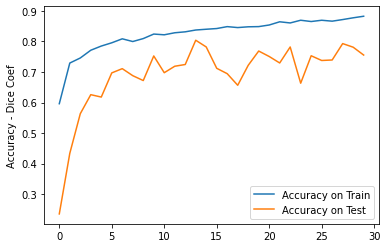

In [ ]:
plt.plot(history.history['dice_coef'], label='Accuracy on Train')
plt.plot(history.history['val_dice_coef'], label='Accuracy on Test')
plt.ylabel('Accuracy - Dice Coef')
plt.legend()
plt.show()

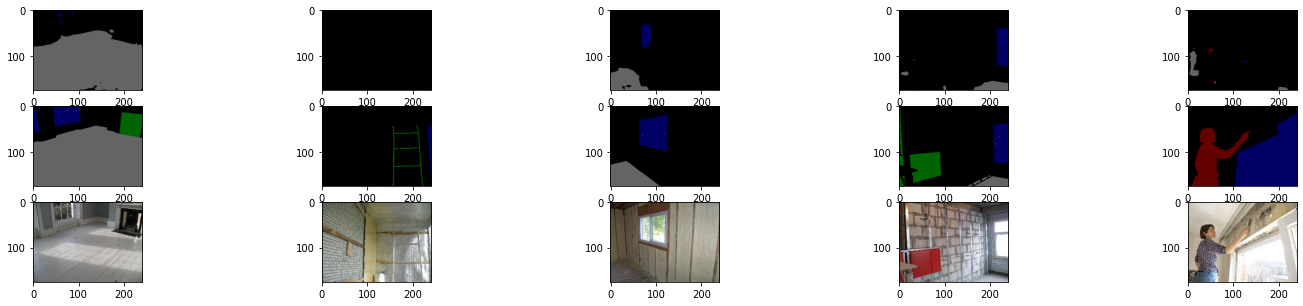

In [ ]:
processImage(modelUnet, 5, num_classes)

###U-net Activation=LeakyReLU

In [ ]:
def unet_LeakyReLU(num_classes = 6, input_shape= (176, 240, 3)):
    img_input = Input(input_shape)                                         # Create input layer with input_shape dimensions

    # Block 1
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation layer

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_1_out = Activation('LeakyReLU')(x)                                    # Add Activation and save as block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Add MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_2_out = Activation('LeakyReLU')(x)                                    # Add Activation and save as block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Add MaxPooling2D

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)        # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_3_out = Activation('LeakyReLU')(x)                                    # Add Activation and save as block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Add MaxPooling2D

    # Block 4
    x = Conv2D(64, (3, 3), padding='same', name='block4_conv1')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv2')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same', name='block4_conv3')(x)        # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_4_out = Activation('LeakyReLU')(x)                                    # Add Activation and save as block_4_out

    x = MaxPooling2D()(block_4_out)                                        # Add MaxPooling2D

    # Block 5
    x = Conv2D(32, (3, 3), padding='same', name='block5_conv1')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv2')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(32, (3, 3), padding='same', name='block5_conv3')(x)        # Add Conv2D with 32 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    block_5_out = Activation('LeakyReLU')(x)                                    # Add Activation and save as block_5_out

    # UP 2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = concatenate([x, block_4_out])                                      # Merge above layer with block_4_out
    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                             # Add Conv2D with 64 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Add Conv2DTranspose with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = concatenate([x, block_3_out])                                      # Merge above layer with block_3_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 128 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    # UP 4
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = concatenate([x, block_2_out])                                      # Merge above layer with block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 256 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    # UP 5
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Add Conv2DTranspose with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = concatenate([x, block_1_out])                                      # Merge above layer with block_1_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Add Conv2D with 512 neurons
    x = BatchNormalization()(x)                                            # Add BatchNormalization
    x = Activation('LeakyReLU')(x)                                              # Add Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Add Conv2D with softmax activation with num_classes neurons

    model = Model(img_input, x) # Create a model with input 'img_input' and output 'x'

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])
    return model

In [ ]:
modelUnet = unet_LeakyReLU(num_classes, (img_width, img_height, 3))
history = modelUnet.fit(x_train, y_train, epochs=30, batch_size=15, validation_data=(x_test, y_test))

Epoch 1/30
60/60 [==============================] - 114s 2s/step - loss: 0.7140 - dice_coef: 0.6616 - val_loss: 44.6628 - val_dice_coef: 0.3718
Epoch 2/30
60/60 [==============================] - 116s 2s/step - loss: 0.4994 - dice_coef: 0.7478 - val_loss: 11.9132 - val_dice_coef: 0.3313
Epoch 3/30
60/60 [==============================] - 117s 2s/step - loss: 0.4549 - dice_coef: 0.7761 - val_loss: 4.2707 - val_dice_coef: 0.3566
Epoch 4/30
60/60 [==============================] - 115s 2s/step - loss: 0.4468 - dice_coef: 0.7782 - val_loss: 3.6949 - val_dice_coef: 0.4027
Epoch 5/30
60/60 [==============================] - 117s 2s/step - loss: 0.4085 - dice_coef: 0.7979 - val_loss: 0.8737 - val_dice_coef: 0.5889
Epoch 6/30
60/60 [==============================] - 116s 2s/step - loss: 0.4263 - dice_coef: 0.7927 - val_loss: 2.1374 - val_dice_coef: 0.4699
Epoch 7/30
60/60 [==============================] - 114s 2s/step - loss: 0.4012 - dice_coef: 0.8025 - val_loss: 1.0522 - val_dice_coef: 0.65

#Conclusion

U-Net Models with different Batch_sizes (Activation relu):
- Batch_size 15        = 78.50%
- Batch_size  5        = 78.27%

U-Net Models with different Activation functions (Batch_size 15):
- Activation elu       = 75.53%
- Activation LeakyReLU = 79.19%

U-Net model with smallest batch size is not more efficient, also based on previous experience we can asume that a large batch size will not give us the best efficience too (unfortunately there was not enought GPU to check this in this project), so batch size=15 is optimal here. However U-Net model with LeakyReLU activation function shows the best result.
